In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import MultiViewMultiLabelMetaDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import multitask_train
from src.test import test_multitask
import random 
import pandas as pd

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Model parameters.
EPOCHS = 10
EMBED_DIM = 512
NUM_ENCODER_LAYERS = 1 #4
NUM_HEADS = 8

# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\BRSET\\data\\'
DOWNLOAD = False
IMAGES = os.path.join(DATASET, 'resized_fundus_photos')
TEST_SIZE = 0.5
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'cleaned_label_paired_eyes.csv')
IMG_COL_LIST=['file_1']

"""
ImageNet Mean and Std:
"""
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

LABEL_COL_LIST = ['diabetic_retinopathy','increased_cup_disc','macular_edema','myopic_fundus','amd'] 
LABEL = LABEL_COL_LIST[0]
META_COL_LIST = ['patient_sex','patient_age_bin','hyp','bin_db_time','diabetes']
                           
BACKBONE = 'resnet18'
LOAD_PRETRAINED = False
MODE = 'fine_tune'
backbone_mode = 'fine_tune'
PARTITION_BY_PATIENT = True
HIDDEN = [128, 128]
num_classes = 2

BATCH_SIZE = 16 
NUM_WORKERS = 8 

LOSS = None
OPTIMIZER = 'adam'

USE_RELU = True 
# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5 #0.5e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\TEST\\metafusion_dr\\'



In [4]:
df = pd.read_csv(LABELS_PATH)


In [5]:
def check_output_cnt(df, labels):
    for label in labels:
        print(label, sum(df[label])/len(df))
   

Train data shape: (7612, 39)
Test data shape: (7612, 39)


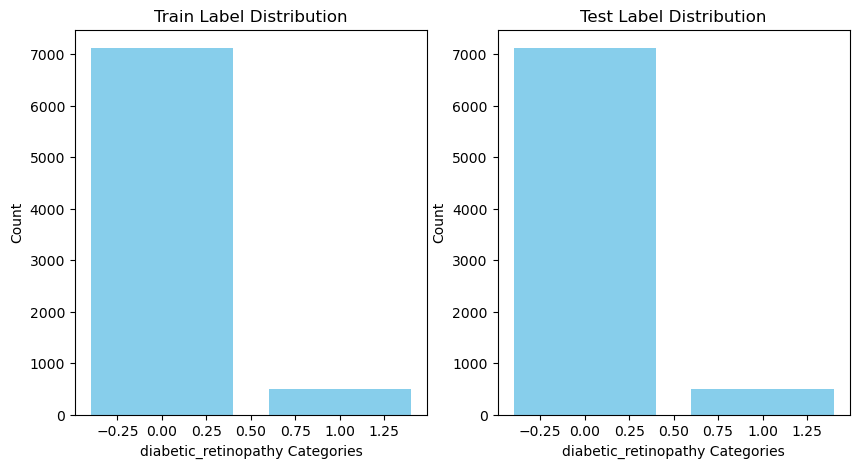

Train data shape: (3806, 39)
Test data shape: (3806, 39)


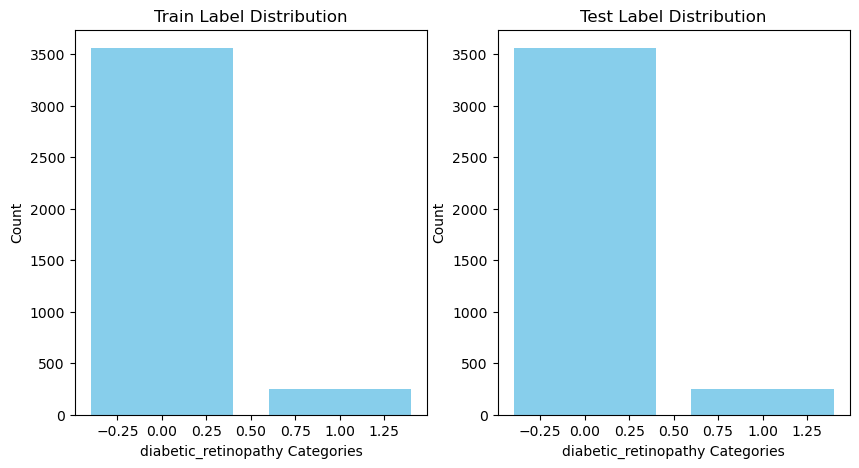

train
diabetic_retinopathy 0.06660535995796112
increased_cup_disc 0.2011297950604309
macular_edema 0.02167630057803468
myopic_fundus 0.017735155018392013
amd 0.019048870204939568
test
diabetic_retinopathy 0.06647398843930635
increased_cup_disc 0.18759852863899107
macular_edema 0.023384130320546506
myopic_fundus 0.012611665790856543
amd 0.017603783499737256
val
diabetic_retinopathy 0.05990541250656858
increased_cup_disc 0.20178665265370468
macular_edema 0.02259590120861797
myopic_fundus 0.016815554387808723
amd 0.019180241723594324


In [6]:
if PARTITION_BY_PATIENT:
    print('Partitioning by patient')
    ## LOGIC for partitioning by patient
    # Separate out patients for training and test
    k = 2
    df_subsampled = df.iloc[::k]
    df_patient = df_subsampled[['patient_id',LABEL]]
    df_patient.head()
    #split=0.2
    df_patient_train, df_patient_test = split_data(df_patient, LABEL, TEST_SIZE, undersample=False, random_state = 42)
    # Now find all rows in df for the patients in df_train
    train_patients = list(df_patient_train['patient_id'])
    
    df_train = df[df['patient_id'].isin(train_patients)]
    
    print('Getting validation set...')
    
    df_patient_test, df_patient_val = split_data(df_patient_test, LABEL, 0.50,random_state = 42)
    test_patients = list(df_patient_test['patient_id'])
    df_test = df[df['patient_id'].isin(test_patients)]
    
    val_patients = list(df_patient_val['patient_id'])
    df_val = df[df['patient_id'].isin(val_patients)]
    print(df_val.shape)
else:
    df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False, random_state=42)
    df_test, df_val = split_data(df_test, LABEL, 0.50,random_state = 42)





In [7]:
# Define the target image shape
SHAPE = (256, 256)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally  
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])


if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In init
['file_1']
torch.Size([7612, 5])
In init
['file_1']
torch.Size([3806, 5])
In init
['file_1']
torch.Size([3806, 5])


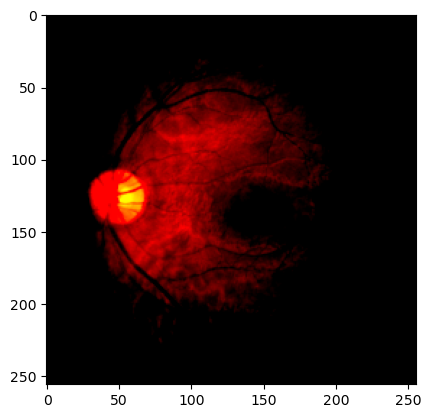

In [8]:
train_dataset = MultiViewMultiLabelMetaDataset(
    df_train, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=train_transforms,
    meta_only=False,
    num_views_per_image=1
)

test_dataset = MultiViewMultiLabelMetaDataset(
    df_test, 
    
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)

val_dataset = MultiViewMultiLabelMetaDataset(
    df_val, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,   
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)
NUM_WORKERS=8
v = test_dataset[0]
images = v['image']
for i in range(len(images)):
    plt.imshow(images[i].permute(1, 2, 0)) 
    plt.show()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)


In [9]:
class FusionLayer(torch.nn.Module):
    def __init__(self, x1_dim, x2_dim):
        super(FusionLayer, self).__init__()
        self.W = nn.Linear(x1_dim, x2_dim)
    
    def forward(self,x1, x2):
        # Project x2 to x1's space
        x2= self.W(x2)
        # Element wise mul
        z = x1*x2
        z = F.tanh(z)
        return x1*z
        
class MetaFusionModel(nn.Module):
    def __init__(self, backbone,num_metadata_features, embed_dim, vision_emb_dim, num_labels):
        super(MetaFusionModel, self).__init__()
        self.backbone = backbone
        self.vision_emb_dim = vision_emb_dim
        self.meta_embed_dim = 512
        self.emb =nn.ModuleList([])
        self.metaToimg1_gates =nn.ModuleList([])
        self.img1Tometa_gates =nn.ModuleList([])

        self.num_metadata_features = num_metadata_features
        self.embed_dim = embed_dim
        for i in range(num_metadata_features):
            self.emb.append(nn.Embedding(16, self.meta_embed_dim))
            self.metaToimg1_gates.append(FusionLayer(self.embed_dim, self.meta_embed_dim))
        # For fusing images
        for i in range(num_metadata_features):
            self.img1Tometa_gates.append(FusionLayer(self.meta_embed_dim, self.embed_dim))

        self.output_linear =nn.ModuleList([])
        for i in range(num_labels):
            self.output_linear.append(nn.Linear(self.meta_embed_dim*self.num_metadata_features+self.embed_dim, 2))

        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.backboneLinear = nn.Linear(self.vision_emb_dim,embed_dim) # 1024 for base, 768 for tiny
        
    
    def forward(self, x_list, x_meta):
        features=[]
        B = x_list[0].size()[0]
        z = self.backbone(x_list[0])
        z = self.dropout(z)
        feat=self.backboneLinear(z)  # b x 1 x 512
            

        y = [None] * self.num_metadata_features
        for i in range(self.num_metadata_features):
            y[i] = self.emb[i](x_meta[:,i])
            y[i] = self.dropout(y[i])
        

        x1 = feat
        for i in range(self.num_metadata_features):
            x1=x1+self.metaToimg1_gates[i](feat,y[i])

        #updating the metadata embeddings with respect to other embeddings
        for i in range(self.num_metadata_features):
            y[i]=y[i] +  self.img1Tometa_gates[i](y[i],feat)
                
          
        x_out = torch.cat([x1]+y, dim=1)
        x_out = self.dropout2(x_out)

        out = [0]*len(self.output_linear)
        for i in range(len(self.output_linear)):
            out[i]=self.output_linear[i](x_out)       
       

        return out       
    

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)

model = MetaFusionModel(
    backbone = backbone_model,
    num_metadata_features = len(META_COL_LIST),
    embed_dim=EMBED_DIM,
    vision_emb_dim=512,
    num_labels = len(LABEL_COL_LIST)
)


torch.Size([1, 512])


In [12]:

criterion_list = []


for i in range(len(LABEL_COL_LIST)):
    
    class_indices = train_dataloader.dataset.df_labels.numpy()[:,i]
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32) 
    print(class_weights)
    criterion =  nn.CrossEntropyLoss(weight=class_weights).to(device)
    criterion_list.append(criterion)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

tensor([0.5357, 7.5069])
tensor([0.6259, 2.4860])
tensor([ 0.5111, 23.0667])
tensor([ 0.5090, 28.1926])
tensor([ 0.5097, 26.2483])


In [13]:
  
if LOAD_PRETRAINED:
    state_dict = torch.load(SAVE_DIR + 'pretrain\\pretrained_model_best.pth')
    # Pop keys that do not have any useful information from pre-training.
    keys_to_pop=['emb.0.weight', 'emb.1.weight', 'output_linear.0.weight', 'output_linear.0.bias', 'output_linear.1.weight', 'output_linear.1.bias','output_linear.2.weight', 'output_linear.2.bias', 'output_linear.3.weight', 'output_linear.3.bias','output_linear.4.weight', 'output_linear.4.bias'] 
    for key in keys_to_pop:    
        state_dict.pop(key,None)
    model.load_state_dict(state_dict, strict=False)
    

taskList = [0,1,2,3,4]
model = multitask_train(model,taskList, train_dataloader, val_dataloader,test_dataloader,
              criterion_list, optimizer, scheduler=scheduler, num_epochs=num_epochs, save=True, save_dir = SAVE_DIR,device="cuda", 
              backbone=f'convnextv2_binary',patience=7) 

AMP True


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [01:08<00:00,  6.91it/s]


Epoch 1
Train loss 0.285, F1 0.743, Acc 0.908, BA 0.859
cm[[6505  600]
 [ 100  407]]
Epoch 1
Train loss 0.618, F1 0.611, Acc 0.684, BA 0.661
cm[[4251 1830]
 [ 576  955]]
Epoch 1
Train loss 0.249, F1 0.671, Acc 0.943, BA 0.864
cm[[7046  401]
 [  36  129]]
Epoch 1
Train loss 0.368, F1 0.549, Acc 0.899, BA 0.709
cm[[6774  703]
 [  66   69]]
Epoch 1
Train loss 0.458, F1 0.532, Acc 0.921, BA 0.588
cm[[6979  488]
 [ 110   35]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:47<00:00,  5.06it/s]


Epoch 1
Val loss 1.121, F1 0.860, Acc 0.962, BA 0.939
cm[[3453  125]
 [  20  208]]
Epoch 1
Val loss 1.121, F1 0.716, Acc 0.774, BA 0.782
cm[[2333  705]
 [ 156  612]]
Epoch 1
Val loss 1.121, F1 0.810, Acc 0.976, BA 0.948
cm[[3635   85]
 [   7   79]]
Epoch 1
Val loss 1.121, F1 0.646, Acc 0.946, BA 0.857
cm[[3550  192]
 [  15   49]]
Epoch 1
Val loss 1.121, F1 0.602, Acc 0.922, BA 0.792
cm[[3461  272]
 [  25   48]]
Mean f1 score 0.727
Mean ba score 0.864


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:47<00:00,  4.97it/s]


Test loss 1.034, F1 0.878, Acc 0.965, BA 0.942
cm[[3439  114]
 [  21  232]]
Test loss 1.034, F1 0.726, Acc 0.790, BA 0.801
cm[[2423  669]
 [ 130  584]]
Test loss 1.034, F1 0.805, Acc 0.973, BA 0.959
cm[[3621   96]
 [   5   84]]
Test loss 1.034, F1 0.619, Acc 0.946, BA 0.860
cm[[3564  194]
 [  11   37]]
Test loss 1.034, F1 0.607, Acc 0.927, BA 0.816
cm[[3481  258]
 [  20   47]]
Saving


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:32<00:00, 14.53it/s]


Epoch 2
Train loss 0.148, F1 0.839, Acc 0.949, BA 0.936
cm[[6756  349]
 [  40  467]]
Epoch 2
Train loss 0.485, F1 0.724, Acc 0.791, BA 0.774
cm[[4879 1202]
 [ 390 1141]]
Epoch 2
Train loss 0.148, F1 0.748, Acc 0.964, BA 0.920
cm[[7197  250]
 [  21  144]]
Epoch 2
Train loss 0.205, F1 0.672, Acc 0.952, BA 0.870
cm[[7144  333]
 [  29  106]]
Epoch 2
Train loss 0.292, F1 0.603, Acc 0.929, BA 0.768
cm[[6986  481]
 [  58   87]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.15it/s]


Epoch 2
Val loss 0.983, F1 0.876, Acc 0.967, BA 0.949
cm[[3467  111]
 [  16  212]]
Epoch 2
Val loss 0.983, F1 0.743, Acc 0.796, BA 0.814
cm[[2381  657]
 [ 119  649]]
Epoch 2
Val loss 0.983, F1 0.815, Acc 0.977, BA 0.948
cm[[3639   81]
 [   7   79]]
Epoch 2
Val loss 0.983, F1 0.642, Acc 0.939, BA 0.892
cm[[3519  223]
 [  10   54]]
Epoch 2
Val loss 0.983, F1 0.636, Acc 0.941, BA 0.809
cm[[3531  202]
 [  24   49]]
Mean f1 score 0.742
Mean ba score 0.883


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.15it/s]


Test loss 0.899, F1 0.899, Acc 0.971, BA 0.957
cm[[3459   94]
 [  15  238]]
Test loss 0.899, F1 0.754, Acc 0.811, BA 0.836
cm[[2462  630]
 [  89  625]]
Test loss 0.899, F1 0.800, Acc 0.973, BA 0.953
cm[[3619   98]
 [   6   83]]
Test loss 0.899, F1 0.627, Acc 0.944, BA 0.910
cm[[3551  207]
 [   6   42]]
Test loss 0.899, F1 0.639, Acc 0.947, BA 0.805
cm[[3561  178]
 [  23   44]]
Saving


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:33<00:00, 14.05it/s]


Epoch 3
Train loss 0.123, F1 0.855, Acc 0.955, BA 0.947
cm[[6795  310]
 [  32  475]]
Epoch 3
Train loss 0.440, F1 0.753, Acc 0.816, BA 0.801
cm[[5019 1062]
 [ 342 1189]]
Epoch 3
Train loss 0.123, F1 0.771, Acc 0.969, BA 0.934
cm[[7230  217]
 [  17  148]]
Epoch 3
Train loss 0.178, F1 0.689, Acc 0.957, BA 0.887
cm[[7173  304]
 [  25  110]]
Epoch 3
Train loss 0.252, F1 0.637, Acc 0.938, BA 0.833
cm[[7034  433]
 [  40  105]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.11it/s]


Epoch 3
Val loss 0.922, F1 0.908, Acc 0.977, BA 0.947
cm[[3512   66]
 [  20  208]]
Epoch 3
Val loss 0.922, F1 0.765, Acc 0.823, BA 0.818
cm[[2512  526]
 [ 147  621]]
Epoch 3
Val loss 0.922, F1 0.827, Acc 0.979, BA 0.944
cm[[3649   71]
 [   8   78]]
Epoch 3
Val loss 0.922, F1 0.636, Acc 0.932, BA 0.919
cm[[3488  254]
 [   6   58]]
Epoch 3
Val loss 0.922, F1 0.645, Acc 0.937, BA 0.861
cm[[3510  223]
 [  16   57]]
Mean f1 score 0.756
Mean ba score 0.898


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 19.88it/s]


Test loss 0.842, F1 0.922, Acc 0.979, BA 0.954
cm[[3493   60]
 [  19  234]]
Test loss 0.842, F1 0.780, Acc 0.840, BA 0.842
cm[[2592  500]
 [ 110  604]]
Test loss 0.842, F1 0.808, Acc 0.975, BA 0.949
cm[[3627   90]
 [   7   82]]
Test loss 0.842, F1 0.615, Acc 0.934, BA 0.936
cm[[3510  248]
 [   3   45]]
Test loss 0.842, F1 0.647, Acc 0.941, BA 0.875
cm[[3528  211]
 [  13   54]]
Saving


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:33<00:00, 14.28it/s]


Epoch 4
Train loss 0.123, F1 0.856, Acc 0.955, BA 0.947
cm[[6797  308]
 [  32  475]]
Epoch 4
Train loss 0.424, F1 0.765, Acc 0.826, BA 0.812
cm[[5080 1001]
 [ 325 1206]]
Epoch 4
Train loss 0.126, F1 0.769, Acc 0.969, BA 0.928
cm[[7231  216]
 [  19  146]]
Epoch 4
Train loss 0.165, F1 0.697, Acc 0.959, BA 0.888
cm[[7193  284]
 [  25  110]]
Epoch 4
Train loss 0.225, F1 0.662, Acc 0.943, BA 0.880
cm[[7061  406]
 [  27  118]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.18it/s]


Epoch 4
Val loss 0.910, F1 0.874, Acc 0.966, BA 0.953
cm[[3461  117]
 [  14  214]]
Epoch 4
Val loss 0.910, F1 0.776, Acc 0.836, BA 0.821
cm[[2569  469]
 [ 157  611]]
Epoch 4
Val loss 0.910, F1 0.811, Acc 0.976, BA 0.948
cm[[3636   84]
 [   7   79]]
Epoch 4
Val loss 0.910, F1 0.627, Acc 0.927, BA 0.909
cm[[3473  269]
 [   7   57]]
Epoch 4
Val loss 0.910, F1 0.649, Acc 0.936, BA 0.887
cm[[3500  233]
 [  12   61]]
Mean f1 score 0.747
Mean ba score 0.904


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:13<00:00, 17.18it/s]


Test loss 0.835, F1 0.905, Acc 0.973, BA 0.969
cm[[3458   95]
 [   9  244]]
Test loss 0.835, F1 0.789, Acc 0.850, BA 0.842
cm[[2642  450]
 [ 121  593]]
Test loss 0.835, F1 0.809, Acc 0.975, BA 0.954
cm[[3626   91]
 [   6   83]]
Test loss 0.835, F1 0.611, Acc 0.932, BA 0.935
cm[[3501  257]
 [   3   45]]
Test loss 0.835, F1 0.654, Acc 0.944, BA 0.876
cm[[3540  199]
 [  13   54]]
Saving


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:33<00:00, 14.35it/s]


Epoch 5
Train loss 0.113, F1 0.855, Acc 0.955, BA 0.946
cm[[6797  308]
 [  33  474]]
Epoch 5
Train loss 0.419, F1 0.769, Acc 0.828, BA 0.819
cm[[5078 1003]
 [ 303 1228]]
Epoch 5
Train loss 0.106, F1 0.781, Acc 0.971, BA 0.938
cm[[7245  202]
 [  16  149]]
Epoch 5
Train loss 0.124, F1 0.738, Acc 0.968, BA 0.922
cm[[7250  227]
 [  17  118]]
Epoch 5
Train loss 0.187, F1 0.674, Acc 0.950, BA 0.870
cm[[7117  350]
 [  31  114]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.52it/s]


Epoch 5
Val loss 0.839, F1 0.895, Acc 0.973, BA 0.953
cm[[3491   87]
 [  16  212]]
Epoch 5
Val loss 0.839, F1 0.767, Acc 0.822, BA 0.828
cm[[2483  555]
 [ 124  644]]
Epoch 5
Val loss 0.839, F1 0.811, Acc 0.976, BA 0.959
cm[[3632   88]
 [   5   81]]
Epoch 5
Val loss 0.839, F1 0.677, Acc 0.953, BA 0.907
cm[[3571  171]
 [   9   55]]
Epoch 5
Val loss 0.839, F1 0.684, Acc 0.952, BA 0.882
cm[[3565  168]
 [  14   59]]
Mean f1 score 0.767
Mean ba score 0.906


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.63it/s]


Test loss 0.753, F1 0.918, Acc 0.977, BA 0.964
cm[[3480   73]
 [  13  240]]
Test loss 0.753, F1 0.782, Acc 0.838, BA 0.854
cm[[2563  529]
 [  87  627]]
Test loss 0.753, F1 0.805, Acc 0.974, BA 0.954
cm[[3623   94]
 [   6   83]]
Test loss 0.753, F1 0.670, Acc 0.961, BA 0.918
cm[[3615  143]
 [   6   42]]
Test loss 0.753, F1 0.674, Acc 0.955, BA 0.860
cm[[3582  157]
 [  16   51]]
Saving


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:33<00:00, 14.36it/s]


Epoch 6
Train loss 0.106, F1 0.869, Acc 0.960, BA 0.959
cm[[6820  285]
 [  21  486]]
Epoch 6
Train loss 0.393, F1 0.776, Acc 0.834, BA 0.823
cm[[5113  968]
 [ 297 1234]]
Epoch 6
Train loss 0.100, F1 0.781, Acc 0.971, BA 0.944
cm[[7239  208]
 [  14  151]]
Epoch 6
Train loss 0.121, F1 0.747, Acc 0.971, BA 0.916
cm[[7273  204]
 [  19  116]]
Epoch 6
Train loss 0.163, F1 0.689, Acc 0.952, BA 0.901
cm[[7124  343]
 [  22  123]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.61it/s]


Epoch 6
Val loss 0.810, F1 0.874, Acc 0.966, BA 0.955
cm[[3460  118]
 [  13  215]]
Epoch 6
Val loss 0.810, F1 0.766, Acc 0.820, BA 0.829
cm[[2473  565]
 [ 120  648]]
Epoch 6
Val loss 0.810, F1 0.824, Acc 0.978, BA 0.949
cm[[3645   75]
 [   7   79]]
Epoch 6
Val loss 0.810, F1 0.693, Acc 0.957, BA 0.917
cm[[3587  155]
 [   8   56]]
Epoch 6
Val loss 0.810, F1 0.719, Acc 0.968, BA 0.836
cm[[3633  100]
 [  22   51]]
Mean f1 score 0.775
Mean ba score 0.897


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 19.85it/s]


Test loss 0.730, F1 0.907, Acc 0.973, BA 0.971
cm[[3460   93]
 [   8  245]]
Test loss 0.730, F1 0.770, Acc 0.828, BA 0.845
cm[[2530  562]
 [  92  622]]
Test loss 0.730, F1 0.818, Acc 0.977, BA 0.950
cm[[3635   82]
 [   7   82]]
Test loss 0.730, F1 0.682, Acc 0.963, BA 0.930
cm[[3624  134]
 [   5   43]]
Test loss 0.730, F1 0.737, Acc 0.972, BA 0.861
cm[[3651   88]
 [  17   50]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:33<00:00, 14.42it/s]


Epoch 7
Train loss 0.108, F1 0.863, Acc 0.958, BA 0.953
cm[[6808  297]
 [  26  481]]
Epoch 7
Train loss 0.404, F1 0.776, Acc 0.833, BA 0.828
cm[[5080 1001]
 [ 274 1257]]
Epoch 7
Train loss 0.101, F1 0.787, Acc 0.973, BA 0.936
cm[[7256  191]
 [  17  148]]
Epoch 7
Train loss 0.118, F1 0.763, Acc 0.974, BA 0.918
cm[[7298  179]
 [  19  116]]
Epoch 7
Train loss 0.143, F1 0.710, Acc 0.959, BA 0.908
cm[[7173  294]
 [  21  124]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.99it/s]


Epoch 7
Val loss 0.842, F1 0.867, Acc 0.964, BA 0.946
cm[[3457  121]
 [  17  211]]
Epoch 7
Val loss 0.842, F1 0.754, Acc 0.804, BA 0.830
cm[[2389  649]
 [  97  671]]
Epoch 7
Val loss 0.842, F1 0.831, Acc 0.980, BA 0.939
cm[[3654   66]
 [   9   77]]
Epoch 7
Val loss 0.842, F1 0.664, Acc 0.947, BA 0.911
cm[[3547  195]
 [   8   56]]
Epoch 7
Val loss 0.842, F1 0.703, Acc 0.960, BA 0.872
cm[[3596  137]
 [  16   57]]
Mean f1 score 0.764
Mean ba score 0.900


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.13it/s]


Test loss 0.765, F1 0.899, Acc 0.971, BA 0.968
cm[[3451  102]
 [   9  244]]
Test loss 0.765, F1 0.760, Acc 0.815, BA 0.849
cm[[2454  638]
 [  68  646]]
Test loss 0.765, F1 0.824, Acc 0.978, BA 0.945
cm[[3641   76]
 [   8   81]]
Test loss 0.765, F1 0.646, Acc 0.950, BA 0.944
cm[[3569  189]
 [   3   45]]
Test loss 0.765, F1 0.711, Acc 0.963, BA 0.893
cm[[3612  127]
 [  12   55]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:32<00:00, 14.45it/s]


Epoch 8
Train loss 0.097, F1 0.875, Acc 0.962, BA 0.963
cm[[6832  273]
 [  18  489]]
Epoch 8
Train loss 0.381, F1 0.786, Acc 0.841, BA 0.836
cm[[5139  942]
 [ 265 1266]]
Epoch 8
Train loss 0.081, F1 0.821, Acc 0.978, BA 0.962
cm[[7290  157]
 [   9  156]]
Epoch 8
Train loss 0.089, F1 0.792, Acc 0.978, BA 0.952
cm[[7317  160]
 [  10  125]]
Epoch 8
Train loss 0.133, F1 0.730, Acc 0.963, BA 0.924
cm[[7205  262]
 [  17  128]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.71it/s]


Epoch 8
Val loss 0.818, F1 0.903, Acc 0.976, BA 0.934
cm[[3514   64]
 [  26  202]]
Epoch 8
Val loss 0.818, F1 0.772, Acc 0.827, BA 0.831
cm[[2502  536]
 [ 124  644]]
Epoch 8
Val loss 0.818, F1 0.857, Acc 0.984, BA 0.952
cm[[3666   54]
 [   7   79]]
Epoch 8
Val loss 0.818, F1 0.712, Acc 0.964, BA 0.905
cm[[3616  126]
 [  10   54]]
Epoch 8
Val loss 0.818, F1 0.746, Acc 0.975, BA 0.826
cm[[3661   72]
 [  24   49]]
Mean f1 score 0.798
Mean ba score 0.890


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.44it/s]


Test loss 0.726, F1 0.928, Acc 0.981, BA 0.955
cm[[3500   53]
 [  19  234]]
Test loss 0.726, F1 0.784, Acc 0.841, BA 0.853
cm[[2579  513]
 [  92  622]]
Test loss 0.726, F1 0.834, Acc 0.980, BA 0.946
cm[[3648   69]
 [   8   81]]
Test loss 0.726, F1 0.685, Acc 0.965, BA 0.921
cm[[3631  127]
 [   6   42]]
Test loss 0.726, F1 0.730, Acc 0.975, BA 0.811
cm[[3667   72]
 [  24   43]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:34<00:00, 13.68it/s]


Epoch 9
Train loss 0.095, F1 0.879, Acc 0.964, BA 0.960
cm[[6850  255]
 [  22  485]]
Epoch 9
Train loss 0.386, F1 0.781, Acc 0.839, BA 0.829
cm[[5141  940]
 [ 288 1243]]
Epoch 9
Train loss 0.096, F1 0.807, Acc 0.976, BA 0.946
cm[[7281  166]
 [  14  151]]
Epoch 9
Train loss 0.096, F1 0.796, Acc 0.979, BA 0.949
cm[[7325  152]
 [  11  124]]
Epoch 9
Train loss 0.118, F1 0.764, Acc 0.970, BA 0.951
cm[[7250  217]
 [  10  135]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:13<00:00, 17.76it/s]


Epoch 9
Val loss 0.813, F1 0.855, Acc 0.959, BA 0.945
cm[[3439  139]
 [  16  212]]
Epoch 9
Val loss 0.813, F1 0.788, Acc 0.847, BA 0.826
cm[[2615  423]
 [ 160  608]]
Epoch 9
Val loss 0.813, F1 0.826, Acc 0.979, BA 0.955
cm[[3645   75]
 [   6   80]]
Epoch 9
Val loss 0.813, F1 0.712, Acc 0.964, BA 0.905
cm[[3616  126]
 [  10   54]]
Epoch 9
Val loss 0.813, F1 0.739, Acc 0.972, BA 0.845
cm[[3647   86]
 [  21   52]]
Mean f1 score 0.784
Mean ba score 0.895


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:12<00:00, 18.97it/s]


Test loss 0.716, F1 0.890, Acc 0.967, BA 0.966
cm[[3438  115]
 [   9  244]]
Test loss 0.716, F1 0.812, Acc 0.870, BA 0.859
cm[[2712  380]
 [ 114  600]]
Test loss 0.716, F1 0.805, Acc 0.973, BA 0.959
cm[[3621   96]
 [   5   84]]
Test loss 0.716, F1 0.693, Acc 0.968, BA 0.912
cm[[3643  115]
 [   7   41]]
Test loss 0.716, F1 0.726, Acc 0.971, BA 0.846
cm[[3648   91]
 [  19   48]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:36<00:00, 12.99it/s]


Epoch 10
Train loss 0.097, F1 0.873, Acc 0.962, BA 0.958
cm[[6835  270]
 [  23  484]]
Epoch 10
Train loss 0.370, F1 0.793, Acc 0.846, BA 0.846
cm[[5143  938]
 [ 236 1295]]
Epoch 10
Train loss 0.083, F1 0.805, Acc 0.975, BA 0.958
cm[[7269  178]
 [  10  155]]
Epoch 10
Train loss 0.084, F1 0.806, Acc 0.980, BA 0.950
cm[[7338  139]
 [  11  124]]
Epoch 10
Train loss 0.114, F1 0.754, Acc 0.969, BA 0.940
cm[[7241  226]
 [  13  132]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.55it/s]


Epoch 10
Val loss 0.840, F1 0.902, Acc 0.976, BA 0.944
cm[[3506   72]
 [  21  207]]
Epoch 10
Val loss 0.840, F1 0.784, Acc 0.841, BA 0.830
cm[[2575  463]
 [ 144  624]]
Epoch 10
Val loss 0.840, F1 0.825, Acc 0.980, BA 0.927
cm[[3654   66]
 [  11   75]]
Epoch 10
Val loss 0.840, F1 0.686, Acc 0.956, BA 0.908
cm[[3583  159]
 [   9   55]]
Epoch 10
Val loss 0.840, F1 0.707, Acc 0.961, BA 0.873
cm[[3601  132]
 [  16   57]]
Mean f1 score 0.781
Mean ba score 0.896


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 19.91it/s]


Test loss 0.732, F1 0.924, Acc 0.980, BA 0.956
cm[[3494   59]
 [  18  235]]
Test loss 0.732, F1 0.800, Acc 0.858, BA 0.856
cm[[2656  436]
 [ 105  609]]
Test loss 0.732, F1 0.822, Acc 0.978, BA 0.934
cm[[3644   73]
 [  10   79]]
Test loss 0.732, F1 0.670, Acc 0.960, BA 0.928
cm[[3611  147]
 [   5   43]]
Test loss 0.732, F1 0.709, Acc 0.963, BA 0.893
cm[[3609  130]
 [  12   55]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:32<00:00, 14.59it/s]


Epoch 11
Train loss 0.099, F1 0.884, Acc 0.966, BA 0.960
cm[[6867  238]
 [  24  483]]
Epoch 11
Train loss 0.366, F1 0.784, Acc 0.840, BA 0.834
cm[[5136  945]
 [ 271 1260]]
Epoch 11
Train loss 0.087, F1 0.806, Acc 0.976, BA 0.949
cm[[7277  170]
 [  13  152]]
Epoch 11
Train loss 0.101, F1 0.784, Acc 0.977, BA 0.937
cm[[7315  162]
 [  14  121]]
Epoch 11
Train loss 0.111, F1 0.745, Acc 0.967, BA 0.929
cm[[7233  234]
 [  16  129]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.04it/s]


Epoch 11
Val loss 0.812, F1 0.890, Acc 0.972, BA 0.944
cm[[3491   87]
 [  20  208]]
Epoch 11
Val loss 0.812, F1 0.779, Acc 0.835, BA 0.832
cm[[2542  496]
 [ 133  635]]
Epoch 11
Val loss 0.812, F1 0.836, Acc 0.981, BA 0.945
cm[[3655   65]
 [   8   78]]
Epoch 11
Val loss 0.812, F1 0.703, Acc 0.962, BA 0.904
cm[[3606  136]
 [  10   54]]
Epoch 11
Val loss 0.812, F1 0.716, Acc 0.966, BA 0.848
cm[[3623  110]
 [  20   53]]
Mean f1 score 0.785
Mean ba score 0.894


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.79it/s]


Test loss 0.715, F1 0.920, Acc 0.978, BA 0.964
cm[[3483   70]
 [  13  240]]
Test loss 0.715, F1 0.795, Acc 0.851, BA 0.858
cm[[2620  472]
 [  94  620]]
Test loss 0.715, F1 0.821, Acc 0.977, BA 0.950
cm[[3637   80]
 [   7   82]]
Test loss 0.715, F1 0.697, Acc 0.966, BA 0.952
cm[[3632  126]
 [   3   45]]
Test loss 0.715, F1 0.727, Acc 0.970, BA 0.867
cm[[3640   99]
 [  16   51]]


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:32<00:00, 14.81it/s]


Epoch 12
Train loss 0.090, F1 0.878, Acc 0.963, BA 0.963
cm[[6842  263]
 [  19  488]]
Epoch 12
Train loss 0.369, F1 0.792, Acc 0.847, BA 0.842
cm[[5168  913]
 [ 254 1277]]
Epoch 12
Train loss 0.087, F1 0.808, Acc 0.976, BA 0.952
cm[[7278  169]
 [  12  153]]
Epoch 12
Train loss 0.077, F1 0.813, Acc 0.981, BA 0.954
cm[[7344  133]
 [  10  125]]
Epoch 12
Train loss 0.114, F1 0.756, Acc 0.969, BA 0.934
cm[[7249  218]
 [  15  130]]


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.17it/s]


Epoch 12
Val loss 0.832, F1 0.900, Acc 0.976, BA 0.932
cm[[3513   65]
 [  27  201]]
Epoch 12
Val loss 0.832, F1 0.786, Acc 0.841, BA 0.836
cm[[2566  472]
 [ 132  636]]
Epoch 12
Val loss 0.832, F1 0.841, Acc 0.983, BA 0.923
cm[[3666   54]
 [  12   74]]
Epoch 12
Val loss 0.832, F1 0.690, Acc 0.956, BA 0.916
cm[[3584  158]
 [   8   56]]
Epoch 12
Val loss 0.832, F1 0.716, Acc 0.961, BA 0.906
cm[[3594  139]
 [  11   62]]
Mean f1 score 0.787
Mean ba score 0.903


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 20.83it/s]

Test loss 0.735, F1 0.929, Acc 0.981, BA 0.953
cm[[3502   51]
 [  20  233]]
Test loss 0.735, F1 0.800, Acc 0.857, BA 0.859
cm[[2643  449]
 [  97  617]]
Test loss 0.735, F1 0.829, Acc 0.980, BA 0.935
cm[[3649   68]
 [  10   79]]
Test loss 0.735, F1 0.669, Acc 0.959, BA 0.938
cm[[3605  153]
 [   4   44]]
Test loss 0.735, F1 0.707, Acc 0.962, BA 0.893
cm[[3607  132]
 [  12   55]]
Early stopping triggered.


In [14]:
state_dict = torch.load(SAVE_DIR + 'fine_tuned_model_best.pth')
model.load_state_dict(state_dict,strict=True)
fundus_decision = test_multitask(model,taskList, test_dataloader, criterion_list, saliency=False, device='cuda')

100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:12<00:00, 19.35it/s]

Test loss 0.753, F1 0.918, Acc 0.977, BA 0.964
cm[[3480   73]
 [  13  240]]
Test loss 0.753, F1 0.782, Acc 0.838, BA 0.854
cm[[2563  529]
 [  87  627]]
Test loss 0.753, F1 0.805, Acc 0.974, BA 0.954
cm[[3623   94]
 [   6   83]]
Test loss 0.753, F1 0.670, Acc 0.961, BA 0.918
cm[[3615  143]
 [   6   42]]
Test loss 0.753, F1 0.674, Acc 0.955, BA 0.860
cm[[3582  157]
 [  16   51]]
